<a href="https://colab.research.google.com/github/PSU-Geofluids-Lab/Geospatial_Analysis/blob/main/ISdA_Code_GTools_V3Fractal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Installation & importing

In [12]:
!pip install requests
!pip install boto3
!pip install pystac

!pip install rasterio
!pip install pyproj
!pip install fsspec
!pip install s3fs
!pip install gstools
!pip install porespy
!pip install pyfastnoisesimd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.27
    Uninstalling botocore-1.38.27:
      Successfully uninstalled botocore-1.38.27
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.23.0 requires botocore<1.38.28,>=1.38.23, but you have botocore 1.38.46 which is incompatible.
  Using cached botocore-1.38.27-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.38.27-py3-none-any.whl (13.6 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.46
    Uninstalling botocore-1.38.46:
      Successfully uninstalled botocore-1.38.46
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 

In [13]:
from urllib.parse import urlparse
import boto3
from pystac import Catalog, StacIO
import rasterio as rio
from pyproj import Transformer
import matplotlib.pyplot as plt
import os
import numpy as np


# Helper functions -
Adding some functions that would be helpful for the data analysis later

In [14]:
def my_read_method(uri):
    """
    Custom read method for pystac that allows reading from S3 URIs.

    Args:
        uri (str): The URI of the STAC catalog or item.

    Returns:
        str: The content of the file as a string.
    """
    parsed = urlparse(uri)
    if parsed.scheme == 's3':
        bucket = parsed.netloc
        key = parsed.path[1:]
        s3 = boto3.resource('s3')
        obj = s3.Object(bucket, key)
        return obj.get()['Body'].read().decode('utf-8')
    else:
        return StacIO.default_read_text_method(uri)


def get_data_subset(start_lat_lon, end_lat_lon, file_location):
    '''
    Retrieves a subset of data from a raster file based on a bounding box.

    Args:
        start_lat_lon (tuple): The upper left corner of the bounding box as (latitude, longitude).
        end_lat_lon (tuple): The lower right corner of the bounding box as (latitude, longitude).
        file_location (str): The path or URI of the raster file.

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: The subset of the dataset.
            - dict: Metadata required for writing the subset back to a GeoTIFF file.
    '''
    with rio.open(file_location) as file:
        transformer = Transformer.from_crs("epsg:4326", file.crs)

        # convert the data from lat/lon to x,y coords of the source dataset crs
        start_coords = transformer.transform(start_lat_lon[0], start_lat_lon[1])
        end_coords = transformer.transform(end_lat_lon[0], end_lat_lon[1])
        print(start_coords,end_coords)
        # get the location of the pixel at the given location (in lon/lat (x/y) order))
        start_coords= file.index(start_coords[0], start_coords[1])
        end_coords=file.index(end_coords[0], end_coords[1])

        window = rio.windows.Window(start_coords[1], start_coords[0], end_coords[1] - start_coords[1], end_coords[0] - start_coords[0])


        arr = file.read(window=window)

        new_profile = file.profile.copy()

    new_profile.update({
            'height': window.height,
            'width': window.width,
            'count': file.count,
            'transform': file.window_transform(window)
    })

    return arr, new_profile


def plot_raster(arr, title):
    """
    Plots a single raster image.

    Args:
        arr (numpy.ndarray): The raster data as a NumPy array.
        title (str): The title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12,8), dpi= 100)
    img = ax.imshow(arr)
    fig.colorbar(img, ax=ax)
    ax.set_title(title)
    plt.show()

def plot_grid(arr, titles):
    '''
    Plots a grid of up to four rasters.

    Args:
        arr (list): A list of NumPy arrays, each representing a raster.
        titles (list): A list of strings, each representing the title for the corresponding raster.
    '''
    fig, axs = plt.subplots(2, 2, figsize=(12,8), dpi= 100)
    count=0
    for i in axs:
        for y in i:
            img = y.imshow(arr[count],vmin=np.percentile(arr[count], 1), vmax=np.percentile(arr[count], 99.9))
            fig.colorbar(img, ax=y)
            y.set_title(titles[count])
            count+=1

conversion_funcs = {
    "x": np.vectorize(lambda x: x),
    "x/10": np.vectorize(lambda x: x/10, otypes=["float32"]),
    "x/100": np.vectorize(lambda x: x/100, otypes=["float32"]),
    "expm1(x/10)": np.vectorize(lambda x: np.expm1(x / 10), otypes=["float32"]),
    "%3000": np.vectorize(lambda x: int(x%3000), otypes=["int16"])
}


def write_img_to_file(filename, data, metadata):
    """
    Writes a NumPy array to a GeoTIFF file.

    Args:
        filename (str): The name of the output file.
        data (numpy.ndarray): The data to write.
        metadata (dict): The metadata for the GeoTIFF file.
    """
    with rio.open(filename, 'w', **metadata) as dest:
        if len(data.shape) == 2:
             data=np.array([data])
        dest.write(data)

# What data is available?
First, we can list all of the files available in the iSDAsoil AWS bucket. This consists of data created by iSDA using our machine learning pipeline, but also covariates that were used to predict the soil properties.

iSDAsoil uses the [STAC specification](https://stacspec.org/) to provide metadata about the files we've made available (in the form of `.json` files that live alongside the data). An explanation of STAC is beyond the scope of this tutorial, however we can use the `pystac` library to print out information about the data available in the s3 bucket, including the title, description and URL of the files:

In [15]:
StacIO.read_text_method = my_read_method
catalog = Catalog.from_file("https://isdasoil.s3.amazonaws.com/catalog.json")

assets = {}
for root, catalogs, items in catalog.walk():
    for item in items:
        print(f"Type: {item.get_parent().title}")
        # save all items to a dictionary as we go along
        assets[item.id] = item
        for asset in item.assets.values():
            if asset.roles == ['data']:
                print(f"Title: {asset.title}")
                print(f"Description: {asset.description}")
                print(f"URL: {asset.href}")
                print("------------")

Type: Soil data
Title: Aluminium, extractable
Description: Aluminium, extractable (log transformed) at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/aluminium_extractable/aluminium_extractable.tif
------------
Type: Soil data
Title: Depth to bedrock
Description: Depth to bedrock at 0-200cm depth, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/bedrock_depth/bedrock_depth.tif
------------
Type: Soil data
Title: Bulk density, <2mm fraction
Description: Bulk density, <2mm fraction at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/bulk_density/bulk_density.tif
------------
Type: Soil data
Title: Calcium, extractable
Description: Calcium, extractable (log transformed) at soil depths of 0-20cm and 20-50cm, predicted mean and standard deviation
URL: https://isdasoil.s3.amazonaws.com/soil_data/calcium_extra

# Retrieving a subset of the data

One great feature about Cloud-optimised Geotiffs is that we can request a smaller subset of the total data, based upon on any geography that we are interested in. This is especially useful for the iSDAsoil data, where a single file covers the whole of Africa and can therefore go into the tens (or even hundreds) of gigabytes.

To retrieve a smaller subset of the data (e.g. for a specific country or region), all we have to do is specify the upper left and bottom right coordinates of a bounding box, in lat/lon. Let's take a look at a small area in Zambia. You can view this location on the iSDAsoil frontend by visiting https://www.isda-africa.com/isdasoil/

In [16]:
# beware that if you specify a large area, the request can take a long time
start_lat_lon=(-16.468189, 25.403934)
end_lat_lon=(-16.968189,  25.903934)

#assest_name = "ph"
# "https://isdasoil.s3.amazonaws.com/soil_data/ph/ph.tif"
#URL=assets[assest_name].assets["image"].href

assest_name = "aluminium_extractable"
#URL: https://isdasoil.s3.amazonaws.com/soil_data/aluminium_extractable/aluminium_extractable.tif
URL=assets[assest_name].assets["image"].href


### Working with categorical Data

There are some categorical layers in ISDA -- "One of the layers that they've created is an adaptation of the soil fertility capability classification (FCC) layer, based upon research by Sanchez et. al (2003). This layer aims to give an idea about the specific constraints to soil that may exist at any given location. We have further information on this layer here: https://www.isda-africa.com/isdasoil/faqs/#faq6"


Because .tif image files can only store numeric values, we need a separate file that contains the mapping between the integer values in the .tif file and their true meaning. For any categorical data, there is an accompanying metadata file, the details of which are also contained within the STAC item.

In [6]:
fcc_data, fcc_metadata = get_data_subset(start_lat_lon, end_lat_lon, assets["fcc"].assets["image"].href)
#get the conversion information and do the backtransformation on the values
fcc_conversion = conversion=assets['fcc'].extra_fields["back-transformation"]
fcc_data = conversion_funcs[fcc_conversion](fcc_data)

#get the metadata file
import pandas as pd
fcc_labels = pd.read_csv(assets['fcc'].assets["metadata"].href, index_col=0)

mappings = {val:fcc_labels.loc[int(val),"Description"] for val in np.unique(fcc_data)}

# print the numeric values stored in the file alongside their string representation
for key, value in mappings.items():
  print(f"{key}: {value}")


(2827952.9970259294, -1859005.901287037) (2883612.7424225663, -1917122.3671777924)
0: No constraints
4: Slope
8: High erosion risk - textual contrast
36: Slope, High erosion risk - steep slope
128: Al toxicity
512: Low K
516: Slope, Low K
520: High erosion risk - textual contrast, Low K
640: Al toxicity, Low K
1024: High leaching potential
1536: Low K, High leaching potential
1544: High erosion risk - textual contrast, Low K, High leaching potential


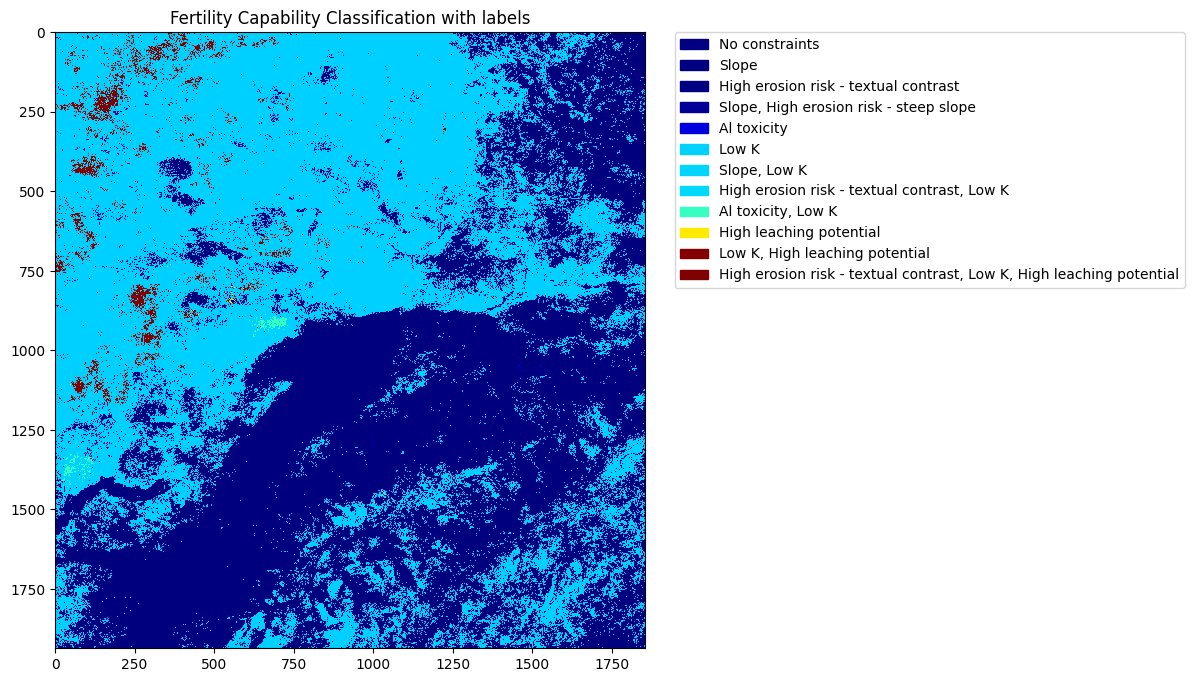

In [7]:
import matplotlib.patches as mpatches

# now plot the FCC layer with labels and a more appropriate colour scheme
plt.figure(figsize=(12,8), dpi= 100)
im = plt.imshow(fcc_data[0], cmap="jet", interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in np.unique(fcc_data[0])]
patches = [mpatches.Patch(color=colors[idx], label=str(mappings[val])) for idx, val in enumerate(np.unique(fcc_data[0]))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.title("Fertility Capability Classification with labels")
plt.show()

## Working with non-Categorical -- numerical data

This is the main focus for the subsequent analysis and requires knowing the back transform and metadata information

In [17]:
assets[assest_name].assets["image"]

<Asset href=https://isdasoil.s3.amazonaws.com/soil_data/aluminium_extractable/aluminium_extractable.tif>

(2827952.9970259294, -1859005.901287037) (2883612.7424225663, -1917122.3671777924)
bands : ['Aluminium, extractable, predicted mean at 0-20 cm depth', 'Aluminium, extractable, predicted mean at 20-50 cm depth', 'Aluminium, extractable, standard deviation at 0-20 cm depth', 'Aluminium, extractable, standard deviation at 20-50 cm depth']
conversion : expm1(x/10)


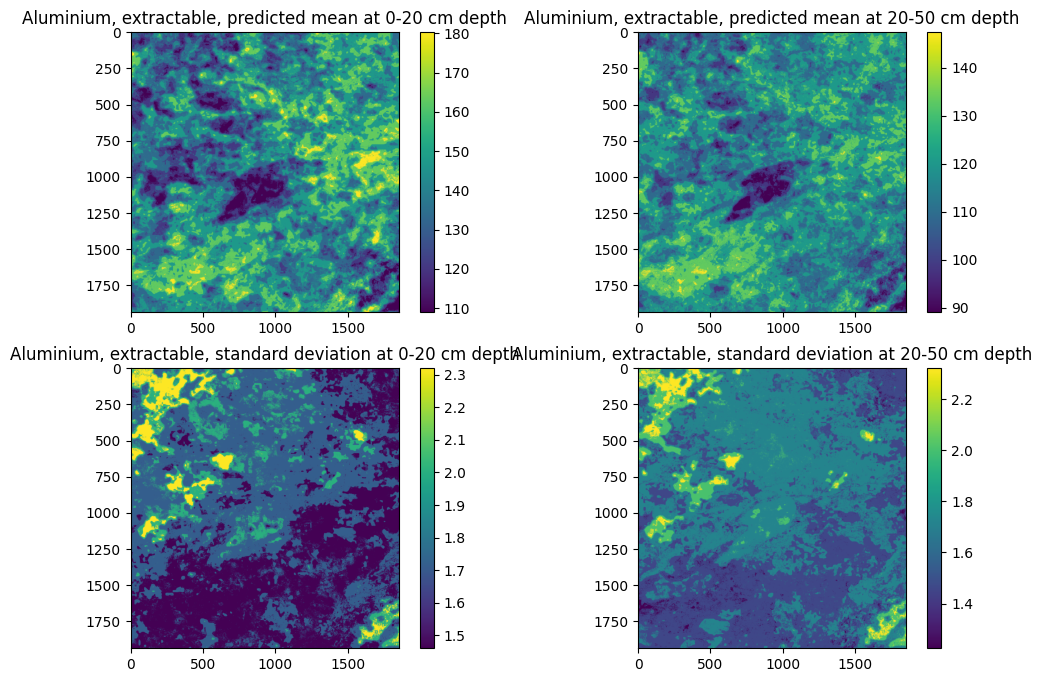

In [18]:
# Convert the data into the correct unit values from what it is stored as in the Geotif
data, metadata = get_data_subset(start_lat_lon, end_lat_lon, URL)
conversion=assets[assest_name].extra_fields["back-transformation"]
bands = assets[assest_name].assets["image"].extra_fields["eo:bands"]

bands = [val['description'] for val in bands]
print(f'bands : {bands}')
print(f'conversion : {conversion}')
transformed_data = conversion_funcs[conversion](data)
plot_grid(transformed_data, bands)
# we can use the previously returned Geotiff metadata, but need to update the dtype due to the transformation
metadata.update(
    {
        'dtype': "float32"
    }
)

#write_img_to_file(f"{assest_name}_Subset_{start_lat_lon}_{end_lat_lon}.tif", transformed_data, metadata)

In [19]:
size_of_each_pixel = 30.0 # m
print(f'Shape of the data : {transformed_data.shape}')
print(f'size of the area covered by the images (in km x km) : {transformed_data.shape[1]*size_of_each_pixel/1e3} km x {transformed_data.shape[2]*size_of_each_pixel/1e3} km')

Shape of the data : (4, 1937, 1856)
size of the area covered by the images (in km x km) : 58.11 km x 55.68 km


In [20]:
print(metadata)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 255.0, 'width': 1856, 'height': 1937, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'), 'transform': Affine(30.0, 0.0, 2827927.1923569688,
       0.0, -30.0, -1858996.8695475701), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}


### 2D spatial coordinates

In [21]:
for i,band in enumerate(bands):
  print(f'Band Number {i}, Description : {band}')

band_chosen = 0

Band Number 0, Description : Aluminium, extractable, predicted mean at 0-20 cm depth
Band Number 1, Description : Aluminium, extractable, predicted mean at 20-50 cm depth
Band Number 2, Description : Aluminium, extractable, standard deviation at 0-20 cm depth
Band Number 3, Description : Aluminium, extractable, standard deviation at 20-50 cm depth


#### Data processing steps

In [22]:
# Assuming transformed_data is the numpy array obtained from the previous steps
# and you want to fit a variogram to the first band (index 0)
field_data = transformed_data[band_chosen,:,:]

# Create coordinates for the data points
# We need coordinates (x, y) for each data point (pixel) in the array.
# We can use the metadata to get the transform which relates pixel coordinates
# to spatial coordinates.
rows, cols = field_data.shape
y_coords, x_coords = np.indices((rows, cols))

# Get the affine transform
transform = metadata['transform']

# Apply the transform to convert pixel coordinates to spatial coordinates
spatial_x, spatial_y = transform * (cols, rows)
spatial_x_coords, spatial_y_coords = transform * (x_coords, y_coords)

# Flatten the data and coordinates for GStools
values = field_data.flatten()
coords = np.vstack((spatial_x_coords.flatten(), spatial_y_coords.flatten())).T

# Filter out any potential NaNs or invalid values if necessary
valid_indices = ~np.isnan(values)
coords_valid = coords[valid_indices]
values_valid = values[valid_indices]


In [23]:
print(transform)

| 30.00, 0.00, 2827927.19|
| 0.00,-30.00,-1858996.87|
| 0.00, 0.00, 1.00|


In [24]:
print(transform.__doc__)

Two dimensional affine transform for 2D linear mapping.

    Parameters
    ----------
    a, b, c, d, e, f : float
        Coefficients of an augmented affine transformation matrix

        | x' |   | a  b  c | | x |
        | y' | = | d  e  f | | y |
        | 1  |   | 0  0  1 | | 1 |

        `a`, `b`, and `c` are the elements of the first row of the
        matrix. `d`, `e`, and `f` are the elements of the second row.

    Attributes
    ----------
    a, b, c, d, e, f, g, h, i : float
        The coefficients of the 3x3 augmented affine transformation
        matrix

        | x' |   | a  b  c | | x |
        | y' | = | d  e  f | | y |
        | 1  |   | g  h  i | | 1 |

        `g`, `h`, and `i` are always 0, 0, and 1.

    The Affine package is derived from Casey Duncan's Planar package.
    See the copyright statement below.  Parallel lines are preserved by
    these transforms. Affine transforms can perform any combination of
    translations, scales/flips, shears, and rotatio

In [25]:
spatial_x_coords

array([[2827927.19235697, 2827957.19235697, 2827987.19235697, ...,
        2883517.19235697, 2883547.19235697, 2883577.19235697],
       [2827927.19235697, 2827957.19235697, 2827987.19235697, ...,
        2883517.19235697, 2883547.19235697, 2883577.19235697],
       [2827927.19235697, 2827957.19235697, 2827987.19235697, ...,
        2883517.19235697, 2883547.19235697, 2883577.19235697],
       ...,
       [2827927.19235697, 2827957.19235697, 2827987.19235697, ...,
        2883517.19235697, 2883547.19235697, 2883577.19235697],
       [2827927.19235697, 2827957.19235697, 2827987.19235697, ...,
        2883517.19235697, 2883547.19235697, 2883577.19235697],
       [2827927.19235697, 2827957.19235697, 2827987.19235697, ...,
        2883517.19235697, 2883547.19235697, 2883577.19235697]])

#### Plotting!

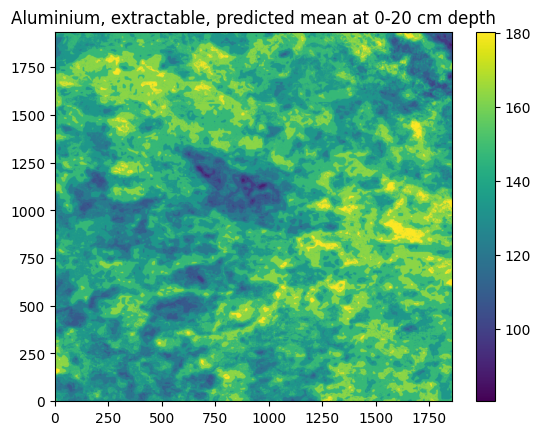

In [26]:
plt.imshow(field_data,aspect='auto',origin='lower',vmax=np.percentile(field_data, 99.9))
plt.colorbar()
plt.title(bands[0])
plt.show()
#

## Variogram Analysis -

Start with a basic example to show what to expect!

## Example Case -- Start with fractal noise

Original:
Exponential(dim=2, var=1.0, len_scale=10.0, anis=[0.5], angles=[0.393])
Fitted:
Exponential(dim=2, var=0.942, len_scale=9.14, anis=[0.529], angles=[0.393])


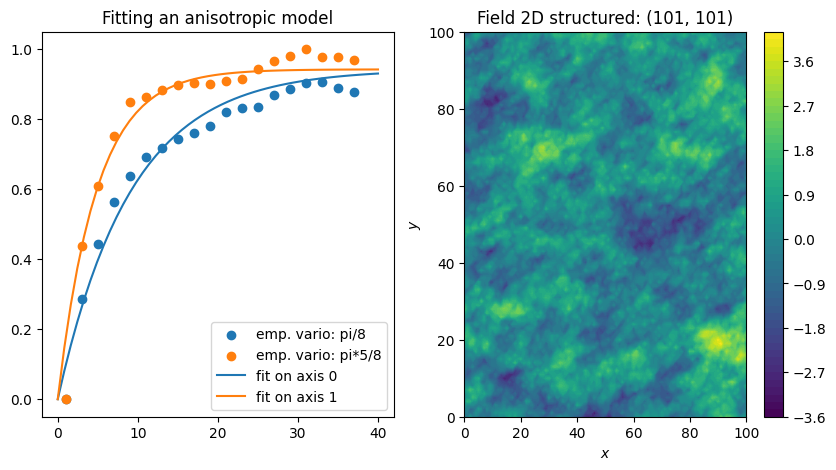

In [24]:
import gstools as gs
angle = np.pi / 8
model = gs.Exponential(dim=2, len_scale=[10, 5], angles=angle)
x = y = range(101)
srf = gs.SRF(model, seed=123456)
field = srf((x, y), mesh_type="structured")

bins = range(0, 40, 2)
bin_center, dir_vario, counts = gs.vario_estimate(
    *((x, y), field, bins),
    direction=gs.rotated_main_axes(dim=2, angles=angle),
    angles_tol=np.pi / 16,
    bandwidth=8,
    mesh_type="structured",
    return_counts=True,
)

print("Original:")
print(model)
model.fit_variogram(bin_center, dir_vario)
print("Fitted:")
print(model)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])

ax1.scatter(bin_center, dir_vario[0], label="emp. vario: pi/8")
ax1.scatter(bin_center, dir_vario[1], label="emp. vario: pi*5/8")
ax1.legend(loc="lower right")

model.plot("vario_axis", axis=0, ax=ax1, x_max=40, label="fit on axis 0")
model.plot("vario_axis", axis=1, ax=ax1, x_max=40, label="fit on axis 1")
ax1.set_title("Fitting an anisotropic model")

srf.plot(ax=ax2)
plt.show()


In [36]:
import porespy as ps
import inspect
inspect.signature(ps.generators.fractal_noise)

import gstools as gs
# model = gs.Exponential(dim=2, len_scale=[10, 5], angles=angle)
x = y = range(100)
field = ps.generators.fractal_noise(shape=(100,100))
# fig, ax = plt.subplots(1, 1, figsize=[4, 4])
# ax.imshow(im, origin='lower', interpolation='none')
# ax.axis(False);

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}

angles = [0.,np.pi / 8, np.pi*2/ 8, np.pi * 4 / 8, np.pi * 6 / 8]

bins = range(0, 60, 2)
bin_center, dir_vario, counts = gs.vario_estimate(
    *((x, y), field, bins),
    angles=angles,
    angles_tol=np.pi / 16,
    bandwidth=8,
    mesh_type="structured",
    return_counts=True,
)

# fit_model = models['Stable'](dim=2)
# fit_model.fit_variogram(bin_center, dir_vario)
# print("Fitted:")
# print(fit_model)



ValueError: CovModel.fit_variogram: Wrong number of empirical variograms! Either provide only one variogram to fit an isotropic model, or directional ones for all main axes to fit anisotropy.

Doing now the same with our data

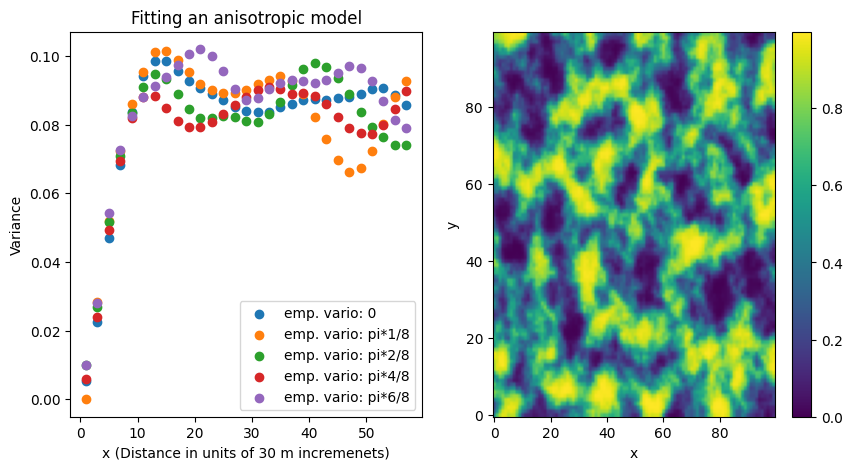

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])

ax1.scatter(bin_center, dir_vario[0], label="emp. vario: 0 ")
ax1.scatter(bin_center, dir_vario[1], label="emp. vario: pi*1/8")
ax1.scatter(bin_center, dir_vario[2], label="emp. vario: pi*2/8")
ax1.scatter(bin_center, dir_vario[3], label="emp. vario: pi*4/8")
ax1.scatter(bin_center, dir_vario[4], label="emp. vario: pi*6/8")
ax1.legend(loc="lower right")

# fit_model.plot("vario_axis", axis=0, ax=ax1, x_max=60, label="fit on axis 0")
# fit_model.plot("vario_axis", axis=1, ax=ax1, x_max=60, label="fit on axis 1")
ax1.set_title("Fitting an anisotropic model")
ax1.set_xlabel("x (Distance in units of 30 m incremenets)")
ax1.set_ylabel("Variance")

dt = ax2.imshow(field,aspect='auto',origin='lower',vmax = np.percentile(field, 99.9))
# ax2.set_title(bands[0])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(dt, ax=ax2)
plt.show()

In [37]:
field_data.shape,field.shape

((1937, 1856), (100, 100))

In [27]:
# x = range(1937)
# y = range(1856)

x = range(101)
y = range(101)


In [28]:
angles = [np.pi / 8, np.pi * 5 / 8]
bins = range(0, 60, 2)
bin_center, dir_vario, counts = gs.vario_estimate(
    *((x,y), field_data[1000:1101,1000:1101], bins),
    angles=angles,
    angles_tol=np.pi / 16,
    bandwidth=10,
    mesh_type="structured",
    return_counts=True,
)

# bin_center, dir_vario, counts = gs.vario_estimate(
#     *((x,y), field_data[:101,:101], bins),
#     direction=gs.rotated_main_axes(dim=2, angles=angle),
#     angles_tol=np.pi / 16,
#     bandwidth=10,
#     mesh_type="structured",
#     return_counts=True,
# )

In [ ]:
dir_vario.shape

(2, 29)

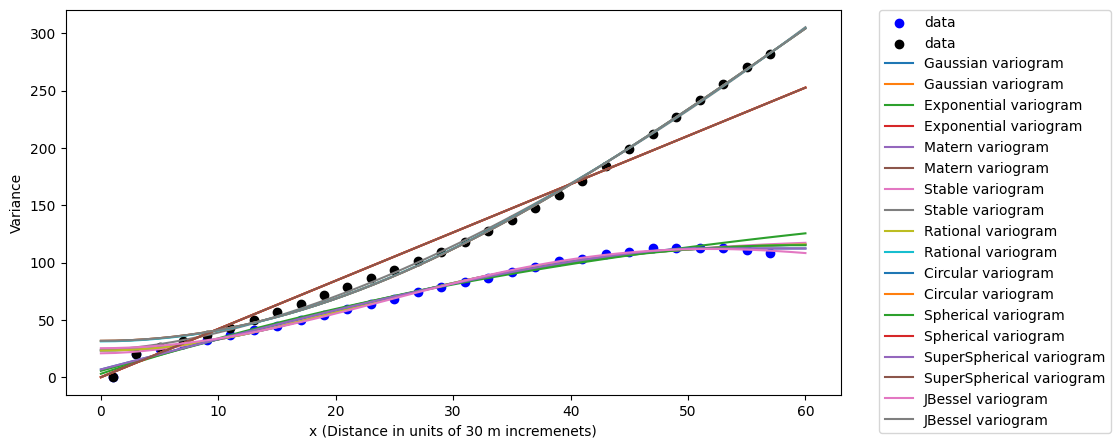

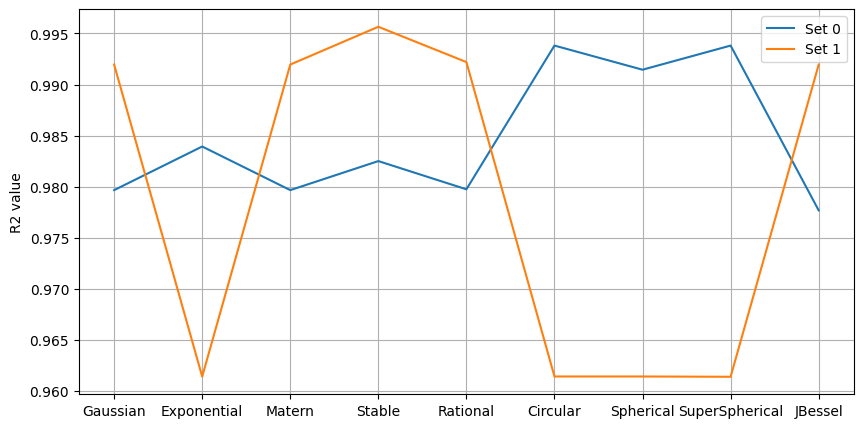

In [29]:
models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores_A = {}
scores_B = {}
plt.figure(figsize=(10, 5))
# plot the estimated variogram
plt.scatter(bin_center, dir_vario[0], color="b", label="data")
plt.scatter(bin_center, dir_vario[1], color="k", label="data")
ax = plt.gca()
ax.set_xlabel("x (Distance in units of 30 m incremenets)")
ax.set_ylabel("Variance")

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, dir_vario[0], return_r2=True,max_eval=1000)
    fit_model.plot(x_max=60, ax=ax)
    scores_A[model] = r2

    para, pcov, r2 = fit_model.fit_variogram(bin_center, dir_vario[1], return_r2=True,max_eval=1000)
    fit_model.plot(x_max=60, ax=ax)
    scores_B[model] = r2
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0. )

# ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
# print("RANKING by Pseudo-r2 score")
# for i, (model, score) in enumerate(ranking, 1):
#     print(f"{i:>6}. {model:>15}: {score:.5}")

plt.figure(figsize=(10, 5))
plt.plot(models.keys(),scores_A.values(),label='Set 0')
plt.plot(models.keys(),scores_B.values(),label='Set 1')
plt.legend()
plt.grid('on')
plt.ylabel('R2 value')
plt.show()

In [30]:
fit_model = gs.SumModel(gs.Spherical, gs.Stable, dim=2)
#fit_model = models['Stable'](dim=2)
fit_model.fit_variogram(bin_center, dir_vario)
print("Fitted:")
print(fit_model)

Fitted:
SumModel(Spherical, Stable, dim=2, vars=[1.7e+03, 2.38e+04], len_scales=[2.41e+03, 1.07e+03], nugget=20.3, anis=[0.634], alpha_1=2.0)


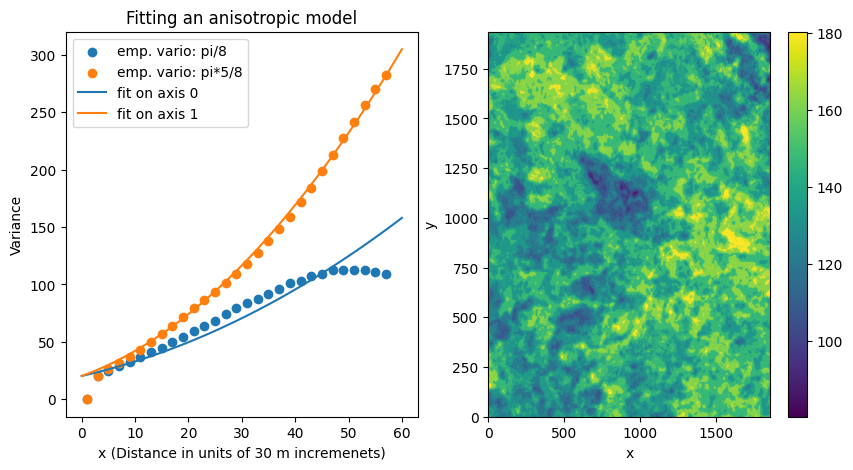

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])

ax1.scatter(bin_center, dir_vario[0], label="emp. vario: pi/8")
ax1.scatter(bin_center, dir_vario[1], label="emp. vario: pi*5/8")
ax1.legend(loc="lower right")

fit_model.plot("vario_axis", axis=0, ax=ax1, x_max=60, label="fit on axis 0")
fit_model.plot("vario_axis", axis=1, ax=ax1, x_max=60, label="fit on axis 1")
ax1.set_title("Fitting an anisotropic model")
ax1.set_xlabel("x (Distance in units of 30 m incremenets)")
ax1.set_ylabel("Variance")

dt = ax2.imshow(field_data,aspect='auto',origin='lower',vmax = np.percentile(field_data, 99.9))
# ax2.set_title(bands[0])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(dt, ax=ax2)
plt.show()

In [32]:
print(f" {fit_model.var=:.2},  {fit_model.len_scale=:.2}")


 fit_model.var=2.5e+04,  fit_model.len_scale=1.2e+03


In [ ]:
def no_of_angles(dim):
    """Calculate number of rotation angles depending on the dimension.

    Parameters
    ----------
    dim : :class:`int`
        spatial dimension

    Returns
    -------
    :class:`int`
        Number of angles.
    """
    return (dim * (dim - 1)) // 2


def set_angles(dim, angles):
    """Set the angles for the given dimension.

    Parameters
    ----------
    dim : :class:`int`
        spatial dimension
    angles : :class:`float` or :class:`list`
        the angles of the SRF

    Returns
    -------
    angles : :class:`float`
        the angles fitting to the dimension

    Notes
    -----
        If too few angles are given, they are filled up with `0`.
    """
    out_angles = np.asarray(angles, dtype=np.double)
    out_angles = np.atleast_1d(out_angles)[: no_of_angles(dim)]
    # fill up the rotation angle array with zeros
    out_angles = np.pad(
        out_angles,
        (0, no_of_angles(dim) - len(out_angles)),
        "constant",
        constant_values=0.0,
    )
    return out_angles
set_angles(2, 5*np.pi / 8)